In [1]:
%load_ext autoreload
%autoreload

import json
import numpy as np
import tqdm
from tqdm import tqdm_notebook
import tqdm
import random
import torch
import sklearn
from sklearn.manifold import TSNE
from transformers import BertTokenizer, BertModel, BertForMaskedLM, BertConfig
from transformers import XLMTokenizer, XLMModel, XLMConfig

from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, SGDClassifier
import inlp, inlp_dataset_handler, inlp_linear_model
import copy
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

I0225 04:49:03.195726 140114912474944 file_utils.py:35] PyTorch version 1.3.1 available.
/home/nlp/ravfogs/anaconda2/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nlp/ravfogs/anaconda2/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nlp/ravfogs/anaconda2/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

In [117]:
with open('tweets.above-100.no-retweets.no-http.txt', "r", encoding = "utf-8") as f:
  lines = f.readlines()

all_tweets = []

for line in tqdm_notebook(lines[:]):
    d = eval(line) #json.loads(line)
    text = d["text"]
    lang = d["lang"]
    all_tweets.append({"text": text.replace("\n", "."), "lang": lang})

In [131]:
data = []
n = 3500

langs = ["en", "ar", "es", "pt", "it", "fr", "in", "hi", "de", "ru", "nl", "ja", "th", "tl"]
langs = ["en", "es", "it", "pt", "ru", "hi", "de", "fr", "ar", "iw", "nl", "fa", "ur", "pl", "mr", "ro", "sv", "ta"]
for lang in langs:    
    lang_tweets = [d for d in all_tweets if d["lang"] == lang]
    print(lang, len(lang_tweets))
    for i in range(n):
        tweet = random.choice(lang_tweets)
        data.append({"lang": lang, "text": tweet["text"]})
        
random.shuffle(data)

en 1091910
es 266762
it 21231
pt 378985
ru 36704
hi 56132
de 15406
fr 57304
ar 143835
iw 3656
nl 12087
fa 7312
ur 9812
pl 5272
mr 1479
ro 863
sv 4199
ta 2362


In [132]:
from collections import Counter
all_langs = [d["lang"] for d in all_tweets]
counter = Counter(all_langs)
print(counter.most_common(100))

[('en', 1091910), ('pt', 378985), ('es', 266762), ('in', 154360), ('ar', 143835), ('tr', 99634), ('tl', 83328), ('ja', 77835), ('fr', 57304), ('hi', 56132), ('ru', 36704), ('th', 30698), ('it', 21231), ('de', 15406), ('nl', 12087), ('ht', 9849), ('ur', 9812), ('fa', 7312), ('ko', 5839), ('pl', 5272), ('ca', 4471), ('sv', 4199), ('fi', 3903), ('iw', 3656), ('ta', 2362), ('et', 2252), ('ne', 2147), ('el', 1840), ('da', 1705), ('uk', 1574), ('zh', 1531), ('mr', 1479), ('cs', 1219), ('bn', 1172), ('ro', 863), ('no', 860), ('te', 633), ('hu', 627), ('sr', 610), ('kn', 562), ('lv', 536), ('cy', 480), ('sl', 477), ('ml', 449), ('si', 438), ('vi', 427), ('ps', 334), ('bg', 263), ('gu', 254), ('sd', 230), ('ckb', 197), ('is', 152), ('dv', 149), ('eu', 147), ('or', 115), ('lt', 103), ('pa', 79), ('am', 66), ('lo', 36), ('my', 30), ('hy', 13), ('ka', 9), ('km', 5), ('ug', 2)]


## Run BERT

In [120]:
class BertEncoder(object):
    
    def __init__(self, device = 'cpu'):

        config = BertConfig.from_pretrained("bert-base-multilingual-cased", output_hidden_states=True)
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
        self.model = BertModel.from_pretrained('bert-base-multilingual-cased', config = config)
        
        #config = XLMConfig.from_pretrained("xlm-mlm-100-1280", output_hidden_states=True)
        #self.tokenizer = XLMTokenizer.from_pretrained("xlm-mlm-100-1280")
        #self.model = XLMModel.from_pretrained("xlm-mlm-100-1280", config = config)

        #config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=True)
        #self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        #self.model = BertModel.from_pretrained('bert-base-uncased', config = config)
        
        #config = AlbertConfig.from_pretrained("albert-xlarge-v2", output_hidden_states=True)
        #self.tokenizer = AlbertTokenizer.from_pretrained("albert-xlarge-v2")
        #self.model = AlbertModel.from_pretrained("albert-xlarge-v2", config = config)
        #config = RobertaConfig.from_pretrained("roberta-large", output_hidden_states=True)
        #self.tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
        #self.model = RobertaModel.from_pretrained('roberta-large', config = config)
            
        self.model.eval()
        self.model.to(device)
        self.device = device
        
    def tokenize(self, original_sentence: List[str], capitalize = False) -> Tuple[List[str], Dict[int, int]]:

        """
        Parameters
        ----------
        Returns
        -------
        bert_tokens: The sentence, tokenized by BERT tokenizer.
        orig_to_tok_map: An output dictionary consisting of a mapping (alignment) between indices in the original tokenized sentence, and indices in the sentence tokenized by the BERT tokenizer. See https://github.com/google-research/bert
        """

        if capitalize:
            
            w = list(original_sentence[0])
            w[0] = w[0].upper()
            
            original_sentence[0] = "".join(w)
            
        bert_tokens = ["[CLS]"]
        orig_to_tok_map = {}
        has_subwords = False
        is_subword = []

        for i, w in enumerate(original_sentence):
            tokenized_w = self.tokenizer.tokenize(w)
            has_subwords = len(tokenized_w) > 1
            is_subword.append(has_subwords)
            bert_tokens.extend(tokenized_w)

            orig_to_tok_map[i] = len(bert_tokens) - 1

        bert_tokens.append("[SEP]")
        
        return (bert_tokens, orig_to_tok_map)

    
    def encode(self, sentence: str, layers: List[int]):
        
        
        tokenized_text, orig2tok = self.tokenize(sentence.split(" "))
        indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_text)
        tokens_tensor = torch.tensor([indexed_tokens]).to(self.device)

        with torch.no_grad():
            outputs = self.model(tokens_tensor)
            if type(self.model) == BertModel:
                predictions = torch.cat([outputs[2][l] for l in layers], axis = 2).detach().cpu().numpy()
            else: #xlm
                predictions = torch.cat([outputs[1][l] for l in layers], axis = 2).detach().cpu().numpy()
            
            """
            if layer >= 0:
                predictions = outputs[2][layer].detach().cpu().numpy()
            else:
                concat = torch.cat(outputs[2], axis = 0)
                concat = concat[:7, :, :]
                predictions = concat.reshape(concat.shape[1], concat.shape[0] * concat.shape[2])
                
                print(predictions.shape)
                print("----------------------------")
                #predictions = torch.sum(concat, axis = 0).detach().cpu().numpy()
            """
            return (predictions.squeeze(), orig2tok)
        
        
        
def collect_bert_states(bert, data: List[Tuple], layers: List[int], strategy = "mean"):
    
        for i,d in tqdm.notebook.tqdm(enumerate(data), total = len(data)):

            sent = d["text"]
            preds, orig2tok = bert.encode(sent, layers = layers)
        
            if strategy == "sum":
                states = np.sum(preds, axis = 0)
            elif strategy == "cls":
                states = preds[0]
            elif strategy == "rand-word":
                states = preds[random.choice(range(len(preds)))]
            data[i]["vec"] = states
    
        return data

In [58]:
bert = BertEncoder(device = "cuda")

I0225 05:55:23.756669 140114912474944 file_utils.py:362] https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json not found in cache or force_download set to True, downloading to /tmp/tmpoihhf2rf
I0225 05:55:24.448838 140114912474944 file_utils.py:377] copying /tmp/tmpoihhf2rf to cache at /home/nlp/ravfogs/.cache/torch/transformers/45629519f3117b89d89fd9c740073d8e4c1f0a70f9842476185100a8afe715d1.893eae5c77904d1e9175faf98909639d3eb20cc7e13e2be395de9a0d8a0dad52
I0225 05:55:24.463012 140114912474944 file_utils.py:381] creating metadata file for /home/nlp/ravfogs/.cache/torch/transformers/45629519f3117b89d89fd9c740073d8e4c1f0a70f9842476185100a8afe715d1.893eae5c77904d1e9175faf98909639d3eb20cc7e13e2be395de9a0d8a0dad52
I0225 05:55:24.465374 140114912474944 file_utils.py:390] removing temp file /tmp/tmpoihhf2rf
I0225 05:55:24.467952 140114912474944 configuration_utils.py:185] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert

In [133]:
data_with_states = collect_bert_states(bert, copy.deepcopy(data)[:], layers = [-1], strategy = "rand-word")

In [137]:
import pickle

with open("data_with_bert_states.pickle", "wb") as f:
    
    pickle.dump(data_with_states, f)

## TSNE by language (Before INLP)

In [135]:
COLORS = [np.random.rand(1,3) for i in range(100)]

def tsne(vecs, labels, title="", ind2label = None, words = None, metric = "l2", color_gradient = False):

  tsne = TSNE(n_components=2, random_state=0, metric = metric)
  vecs_2d = tsne.fit_transform(vecs)
  label_names = sorted(list(set(labels.tolist())))
  num_labels = len(label_names)

  #names = ["digit={}".format(int(i)) for i in labels.tolist()]
  #names = ["class {}".format(i) for i in range(num_labels)]
  names = sorted(set(labels.tolist()))

  plt.figure(figsize=(6, 5))
  colors = "red", "blue", "green", "orange", "black", "grey", "purple", "pink", "brown", "cyan", "magenta", "gold", "brown"
  for i, c, label in zip(sorted(set(labels.tolist())), COLORS, names):
        plt.scatter(vecs_2d[labels == label, 0], vecs_2d[labels == label, 1], c=c,
                    label=label if ind2label is None else ind2label[label], alpha = 0.3)
  plt.legend()
  

  plt.title(title)
  plt.show()

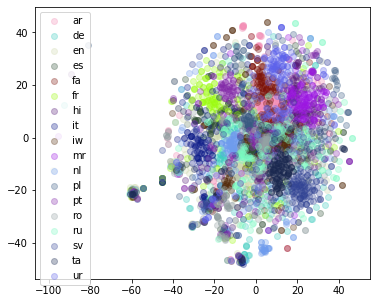

In [136]:
random.shuffle(data_with_states)
vecs = np.array([d["vec"] for d in data_with_states][:])
labels_lang = np.array([d["lang"] for d in data_with_states][:])
tsne(vecs[:3000], labels_lang[:3000])

## Classify language

In [138]:
l = int(len(vecs) * 0.9)
x_train_cls, x_dev_cls = vecs[:l], vecs[l:]
y_train_cls, y_dev_cls = labels_lang[:l], labels_lang[l:]
model = SGDClassifier(max_iter = 1000, alpha = 0.01)
model.fit(x_train_cls, y_train_cls)
print(model.score(x_dev_cls, y_dev_cls))

0.9623809523809523


## Create dataset for INLP

In [140]:
num_examples_per_language = 2000
vecs1, vecs2, labels = [], [], []
for lang in langs:
    relevant = [d for d in data_with_states if d["lang"] == lang]
    rest = [d for d in data_with_states if d["lang"] != lang]
    for i in range(num_examples_per_language):
        positive_pair = random.choice(relevant)["vec"], random.choice(relevant)["vec"]
        negative_pair = random.choice(relevant)["vec"], random.choice(rest)["vec"]
        
        # positive
        
        vecs1.append(positive_pair[0])
        vecs2.append(positive_pair[1])
        labels.append(1)
        
        # negative 
        vecs1.append(negative_pair[0])
        vecs2.append(negative_pair[1])
        labels.append(0)

vecs1, vecs2, labels = sklearn.utils.shuffle(vecs1, vecs2, labels)
vecs1 = np.array(vecs1)
vecs2 = np.array(vecs2)
labels = np.array(labels)
print(vecs1.shape, vecs2.shape, labels.shape)
l = int(len(vecs1) * 0.9)
x_train1, x_dev1 = vecs1[:l], vecs1[l:]
x_train2, x_dev2 = vecs2[:l], vecs2[l:]
y_train, y_dev = labels[:l], labels[l:]

"""
concat_train = np.concatenate([x_train1, x_train2], axis = 1)
concat_dev = np.concatenate([x_dev1, x_dev2], axis = 1)
model = SGDClassifier(max_iter = 1000, alpha = 0.1)
model.fit(concat_train, y_train)
print(model.score(concat_dev, y_dev))
"""

(72000, 768) (72000, 768) (72000,)


'\nconcat_train = np.concatenate([x_train1, x_train2], axis = 1)\nconcat_dev = np.concatenate([x_dev1, x_dev2], axis = 1)\nmodel = SGDClassifier(max_iter = 1000, alpha = 0.1)\nmodel.fit(concat_train, y_train)\nprint(model.score(concat_dev, y_dev))\n'

## Siamese INLP

In [91]:
inlp_dataset = inlp_dataset_handler.SiameseDatasetHandler((x_train1, x_train2), y_train, (x_dev1, x_dev2), y_dev, dropout_rate = 0, Y_train_main = None, Y_dev_main = None, by_class = False, equal_chance_for_main_task_labels = False)
params = {"num_iter": 20, "input_dim": 768, "hidden_dim": 16, "batch_size": 64, "verbose": False, "device": "cpu",
         "compare_by": "dot_product", "same_weights": True}
inlp_model_handler = inlp_linear_model.SiameseLinearClassifier(model_params = params, concat_weights = False)

### Try several different INLP dimensions



  0%|          | 0/5 [00:00<?, ?it/s]

         Name               Type Params
0          l1             Linear   12 K
1  cosine_sim   CosineSimilarity    0  
2     loss_fn  BCEWithLogitsLoss    0  




iteration: 0, accuracy: 0.9410451650619507:   0%|          | 0/5 [03:40<?, ?it/s]

iteration: 0, accuracy: 0.9410451650619507:  20%|██        | 1/5 [03:42<14:49, 222.27s/it]

         Name               Type Params
0          l1             Linear   12 K
1  cosine_sim   CosineSimilarity    0  
2     loss_fn  BCEWithLogitsLoss    0  




iteration: 1, accuracy: 0.9119835495948792:  20%|██        | 1/5 [07:34<14:49, 222.27s/it]

iteration: 1, accuracy: 0.9119835495948792:  40%|████      | 2/5 [07:36<11:17, 225.95s/it]

         Name               Type Params
0          l1             Linear   12 K
1  cosine_sim   CosineSimilarity    0  
2     loss_fn  BCEWithLogitsLoss    0  




iteration: 2, accuracy: 0.8590686321258545:  40%|████      | 2/5 [11:47<11:17, 225.95s/it]

iteration: 2, accuracy: 0.8590686321258545:  60%|██████    | 3/5 [11:48<07:47, 233.77s/it]

         Name               Type Params
0          l1             Linear   12 K
1  cosine_sim   CosineSimilarity    0  
2     loss_fn  BCEWithLogitsLoss    0  




iteration: 3, accuracy: 0.795518159866333:  60%|██████    | 3/5 [15:45<07:47, 233.77s/it] 

iteration: 3, accuracy: 0.795518159866333:  80%|████████  | 4/5 [15:47<03:55, 235.23s/it]

         Name               Type Params
0          l1             Linear   12 K
1  cosine_sim   CosineSimilarity    0  
2     loss_fn  BCEWithLogitsLoss    0  




iteration: 4, accuracy: 0.7302608489990234:  80%|████████  | 4/5 [19:38<03:55, 235.23s/it]

iteration: 4, accuracy: 0.7302608489990234: 100%|██████████| 5/5 [19:40<00:00, 236.09s/it]


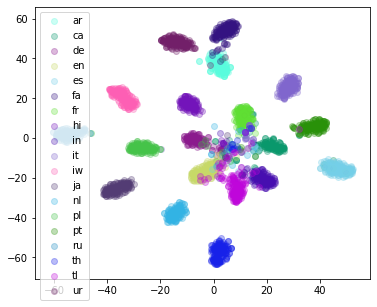

In [92]:
for num_classifiers in [5]:
    P, rowspace_projections, Ws = inlp.run_INLP(num_classifiers = num_classifiers, input_dim = 768, is_autoregressive = True, min_accuracy = 0, dataset_handler = inlp_dataset, model = inlp_model_handler)
    P_rowspace = np.eye(P.shape[0]) - P
    tsne(P_rowspace.dot(vecs.T).T[:3000], labels_lang[:3000])

## Classification INLP

In [141]:
inlp_dataset = inlp_dataset_handler.ClassificationDatasetHandler(x_train_cls, y_train_cls, x_dev_cls, y_dev_cls, dropout_rate = 0, Y_train_main = None, Y_dev_main = None, by_class = False, equal_chance_for_main_task_labels = False)
#inlp_model_handler = inlp_linear_model.SKlearnClassifier(LinearSVC, {"dual": False, "max_iter": 5000})
inlp_model_handler = inlp_linear_model.SKlearnClassifier(SGDClassifier, {"max_iter": 10000, "alpha": 0.0001, "n_iter_no_change": 10})

### Try several different INLP dimensions



  0%|          | 0/1 [00:00<?, ?it/s]

iteration: 0, accuracy: 0.9644444444444444:   0%|          | 0/1 [00:33<?, ?it/s]

iteration: 0, accuracy: 0.9644444444444444: 100%|██████████| 1/1 [00:33<00:00, 33.75s/it]


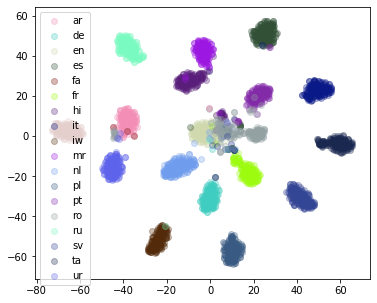



  0%|          | 0/2 [00:00<?, ?it/s]

iteration: 0, accuracy: 0.9628571428571429:   0%|          | 0/2 [00:26<?, ?it/s]

iteration: 0, accuracy: 0.9628571428571429:  50%|█████     | 1/2 [00:27<00:27, 27.09s/it]

iteration: 1, accuracy: 0.9366666666666666:  50%|█████     | 1/2 [01:07<00:27, 27.09s/it]

iteration: 1, accuracy: 0.9366666666666666: 100%|██████████| 2/2 [01:08<00:00, 34.12s/it]


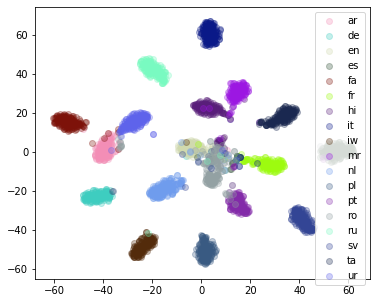



  0%|          | 0/3 [00:00<?, ?it/s]

iteration: 0, accuracy: 0.9639682539682539:   0%|          | 0/3 [00:25<?, ?it/s]

iteration: 0, accuracy: 0.9639682539682539:  33%|███▎      | 1/3 [00:25<00:51, 25.70s/it]

iteration: 1, accuracy: 0.9382539682539682:  33%|███▎      | 1/3 [01:05<00:51, 25.70s/it]

iteration: 1, accuracy: 0.9382539682539682:  67%|██████▋   | 2/3 [01:05<00:30, 30.05s/it]

iteration: 2, accuracy: 0.9058730158730158:  67%|██████▋   | 2/3 [01:55<00:30, 30.05s/it]

iteration: 2, accuracy: 0.9058730158730158: 100%|██████████| 3/3 [01:55<00:00, 38.62s/it]


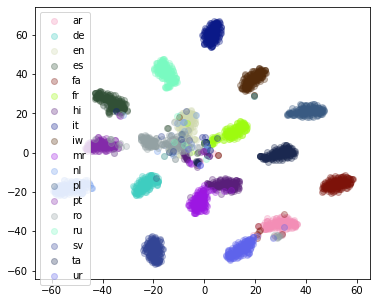



  0%|          | 0/4 [00:00<?, ?it/s]

iteration: 0, accuracy: 0.9642857142857143:   0%|          | 0/4 [00:25<?, ?it/s]

iteration: 0, accuracy: 0.9642857142857143:  25%|██▌       | 1/4 [00:26<01:18, 26.12s/it]

iteration: 1, accuracy: 0.9395238095238095:  25%|██▌       | 1/4 [01:07<01:18, 26.12s/it]

iteration: 1, accuracy: 0.9395238095238095:  50%|█████     | 2/4 [01:08<01:01, 30.98s/it]

iteration: 2, accuracy: 0.9022222222222223:  50%|█████     | 2/4 [01:54<01:01, 30.98s/it]

iteration: 2, accuracy: 0.9022222222222223:  75%|███████▌  | 3/4 [01:54<00:35, 35.65s/it]

iteration: 3, accuracy: 0.8417460317460318:  75%|███████▌  | 3/4 [02:51<00:35, 35.65s/it]

iteration: 3, accuracy: 0.8417460317460318: 100%|██████████| 4/4 [02:52<00:00, 43.03s/it]


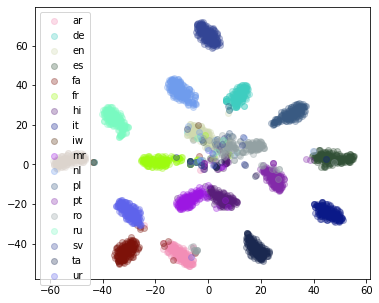

In [149]:
for num_classifiers in [1,2,3,4]:
    P, rowspace_projections, Ws = inlp.run_INLP(num_classifiers = num_classifiers, input_dim = 768, is_autoregressive = True, min_accuracy = 0, dataset_handler = inlp_dataset, model = inlp_model_handler)
    P_rowspace = np.eye(P.shape[0]) - P
    tsne(P_rowspace.dot(vecs.T).T[:3000], labels_lang[:3000])

### Draw a dendrogram

In [150]:
lang_vecs = {}
for lang in langs:
       relevant = [d for d in data_with_states if d["lang"] == lang]
       vecs_relevant = np.array([d["vec"] for d in relevant])
       lang_vecs[lang] = np.median(vecs_relevant, axis = 0)

In [151]:
vecs_for_all_languages = [lang_vecs[lang] for lang in langs]

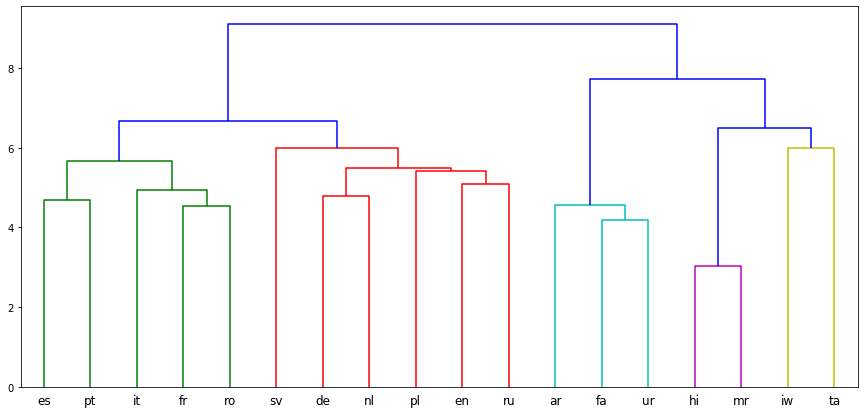

In [152]:
linked = linkage(vecs_for_all_languages, 'ward')
plt.figure(figsize=(15, 7))
dendrogram(
            linked,
            orientation='top',
            labels=langs,
            distance_sort='descending',
            show_leaf_counts=False,
            leaf_rotation = 0
          )
plt.show()